In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, RobustScaler
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.stats.api as sms
from math import ceil
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from pygam import GAM, s
import sklearn
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# FanGraphs leaderboard (example)
url = "https://raw.githubusercontent.com/Chrisboatto/On-base-Predictive-Model/refs/heads/main/batting%20-%20batting.csv"
df = pd.read_csv(url)
df.head()

,playerid,Name,Team,MarApr_PA,MarApr_AB,MarApr_H,MarApr_HR,MarApr_R,MarApr_RBI,MarApr_SB,...,MarApr_FB%,MarApr_IFFB%,MarApr_HR/FB,MarApr_O-Swing%,MarApr_Z-Swing%,MarApr_Swing%,MarApr_O-Contact%,MarApr_Z-Contact%,MarApr_Contact%,FullSeason_OBP
0,15998,Cody Bellinger,LAD,132,109,47,14,32,37,5,...,36.10%,5.70%,40.00%,22.60%,66.00%,40.70%,81.10%,88.40%,86.00%,0.406
1,11477,Christian Yelich,MIL,124,102,36,14,26,34,6,...,41.00%,11.80%,41.20%,27.90%,72.40%,44.80%,56.60%,87.80%,75.70%,0.429
2,17975,Scott Kingery,PHI,35,32,13,2,5,6,1,...,33.30%,0.00%,22.20%,40.20%,74.50%,53.50%,54.30%,85.40%,71.10%,0.315
3,7927,Eric Sogard,TOR,49,43,17,3,8,9,2,...,40.50%,0.00%,20.00%,27.30%,50.50%,37.30%,93.90%,97.80%,96.20%,0.353
4,14130,Daniel Vogelbach,SEA,92,71,22,8,15,16,0,...,51.90%,7.40%,29.60%,23.70%,48.80%,33.70%,66.10%,82.70%,75.70%,0.341


In [3]:
# 1. Summary and structure
print(df.describe())
print("\nData types and info:")
print(df.info())

# 2. Check for missing values
print("\nTotal NA values:")
print(df.isna().sum().sum())

# 3. Data cleaning: Remove Name and Team columns, convert % columns to numeric
df = df.drop(columns=['Name', 'Team'])

# Remove % signs and convert to numeric
df = df.replace('%', '', regex=True).apply(pd.to_numeric, errors='coerce')

# Optional: Reset index if needed
df = df.reset_index(drop=True)

           playerid   MarApr_PA   MarApr_AB    MarApr_H   MarApr_HR  \
count    320.000000  320.000000  320.000000  320.000000  320.000000   
mean   11258.656250   90.418750   80.071875   20.496875    3.371875   
std     4528.990696   29.412209   25.937189    8.491928    2.524331   
min      785.000000   30.000000   24.000000    4.000000    0.000000   
25%     8066.500000   69.000000   61.750000   14.000000    1.000000   
50%    11919.000000   94.500000   84.000000   20.500000    3.000000   
75%    14736.750000  114.250000  102.000000   27.000000    5.000000   
max    20123.000000  135.000000  123.000000   47.000000   14.000000   

         MarApr_R  MarApr_RBI   MarApr_SB  MarApr_ISO  MarApr_BABIP  \
count  320.000000  320.000000  320.000000  320.000000    320.000000   
mean    11.528125   11.131250    1.212500    0.185422      0.297731   
std      5.756214    6.179267    1.777207    0.087236      0.070063   
min      1.000000    0.000000    0.000000    0.000000      0.141000   
25%  

In [4]:
df.head()

,playerid,MarApr_PA,MarApr_AB,MarApr_H,MarApr_HR,MarApr_R,MarApr_RBI,MarApr_SB,MarApr_BB%,MarApr_K%,...,MarApr_FB%,MarApr_IFFB%,MarApr_HR/FB,MarApr_O-Swing%,MarApr_Z-Swing%,MarApr_Swing%,MarApr_O-Contact%,MarApr_Z-Contact%,MarApr_Contact%,FullSeason_OBP
0,15998,132,109,47,14,32,37,5,14.4,11.4,...,36.1,5.7,40.0,22.6,66.0,40.7,81.1,88.4,86.0,0.406
1,11477,124,102,36,14,26,34,6,16.1,16.1,...,41.0,11.8,41.2,27.9,72.4,44.8,56.6,87.8,75.7,0.429
2,17975,35,32,13,2,5,6,1,2.9,14.3,...,33.3,0.0,22.2,40.2,74.5,53.5,54.3,85.4,71.1,0.315
3,7927,49,43,17,3,8,9,2,10.2,10.2,...,40.5,0.0,20.0,27.3,50.5,37.3,93.9,97.8,96.2,0.353
4,14130,92,71,22,8,15,16,0,21.7,21.7,...,51.9,7.4,29.6,23.7,48.8,33.7,66.1,82.7,75.7,0.341


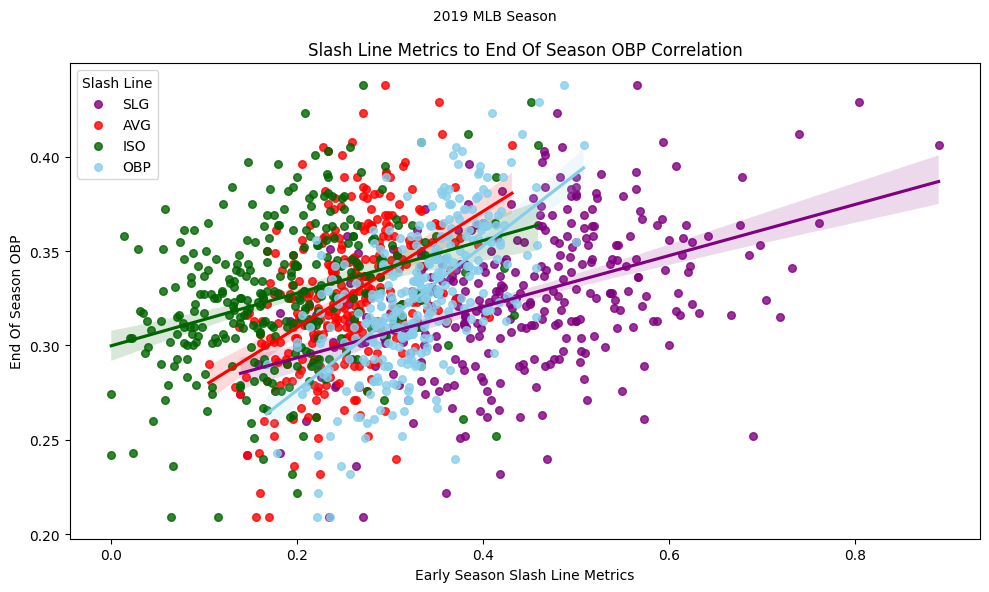

In [5]:
# 4. First Plot: Slash Line Metrics vs FullSeason_OBP
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='MarApr_SLG', y='FullSeason_OBP', 
            scatter_kws={'s': 30}, label='SLG', color='purple', ci=90)
sns.regplot(data=df, x='MarApr_AVG', y='FullSeason_OBP', 
            scatter_kws={'s': 30}, label='AVG', color='red', ci=90)
sns.regplot(data=df, x='MarApr_ISO', y='FullSeason_OBP', 
            scatter_kws={'s': 30}, label='ISO', color='darkgreen', ci=90)
sns.regplot(data=df, x='MarApr_OBP', y='FullSeason_OBP', 
            scatter_kws={'s': 30}, label='OBP', color='skyblue', ci=90)

plt.title("Slash Line Metrics to End Of Season OBP Correlation")
plt.xlabel("Early Season Slash Line Metrics")
plt.ylabel("End Of Season OBP")
plt.suptitle("2019 MLB Season", y=0.98, fontsize=10)
plt.legend(title="Slash Line")
plt.tight_layout()
plt.savefig(r'C:\Users\cboat\OneDrive\Documents\GitHub\On-base-Predictive-Model\Slash Lines.png')
plt.show()

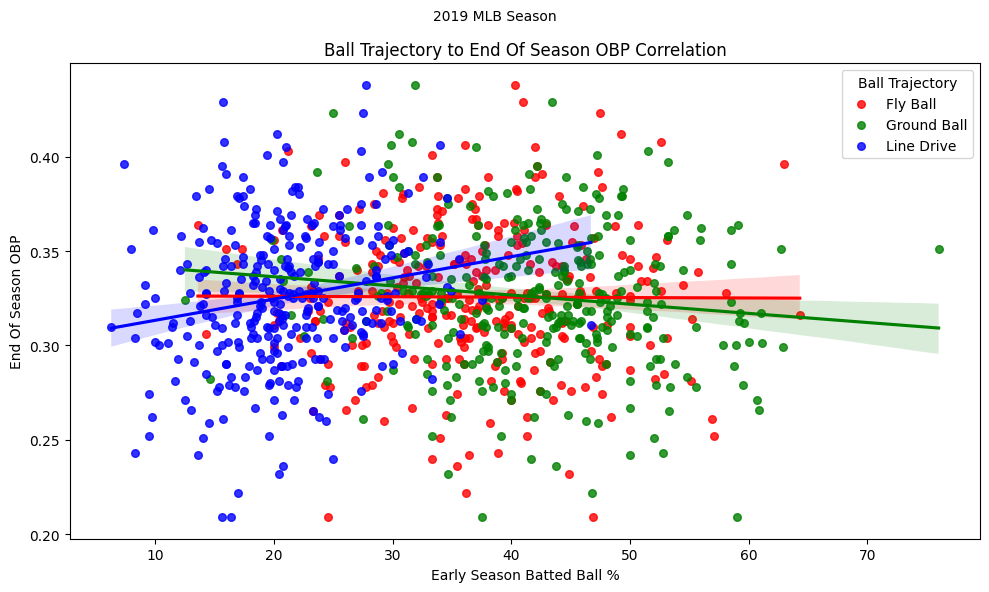

In [6]:
# 5. Second Plot: Batted Ball Trajectory vs FullSeason_OBP
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='MarApr_FB%', y='FullSeason_OBP', 
            scatter_kws={'s': 30}, label='Fly Ball', color='red', ci=90)
sns.regplot(data=df, x='MarApr_GB%', y='FullSeason_OBP', 
            scatter_kws={'s': 30}, label='Ground Ball', color='green', ci=90)
sns.regplot(data=df, x='MarApr_LD%', y='FullSeason_OBP', 
            scatter_kws={'s': 30}, label='Line Drive', color='blue', ci=90)

plt.title("Ball Trajectory to End Of Season OBP Correlation")
plt.xlabel("Early Season Batted Ball %")
plt.ylabel("End Of Season OBP")
plt.suptitle("2019 MLB Season", y=0.98, fontsize=10)
plt.legend(title="Ball Trajectory")
plt.tight_layout()
plt.savefig(r'C:\Users\cboat\OneDrive\Documents\GitHub\On-base-Predictive-Model\Ball Trajectory.png')
plt.show()

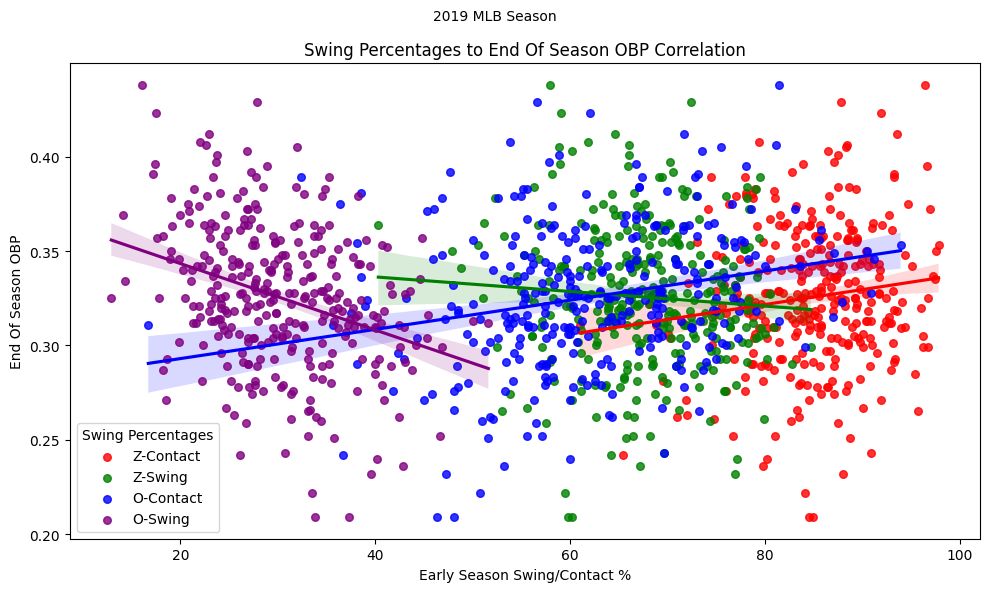

In [7]:
# 6. Third Plot: Swing Percentages vs FullSeason_OBP
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='MarApr_Z-Contact%', y='FullSeason_OBP', 
            scatter_kws={'s': 30}, label='Z-Contact', color='red', ci=90)
sns.regplot(data=df, x='MarApr_Z-Swing%', y='FullSeason_OBP', 
            scatter_kws={'s': 30}, label='Z-Swing', color='green', ci=90)
sns.regplot(data=df, x='MarApr_O-Contact%', y='FullSeason_OBP', 
            scatter_kws={'s': 30}, label='O-Contact', color='blue', ci=90)
sns.regplot(data=df, x='MarApr_O-Swing%', y='FullSeason_OBP', 
            scatter_kws={'s': 30}, label='O-Swing', color='purple', ci=90)

plt.title("Swing Percentages to End Of Season OBP Correlation")
plt.xlabel("Early Season Swing/Contact %")
plt.ylabel("End Of Season OBP")
plt.suptitle("2019 MLB Season", y=0.98, fontsize=10)
plt.legend(title="Swing Percentages")
plt.tight_layout()
plt.savefig(r'C:\Users\cboat\OneDrive\Documents\GitHub\On-base-Predictive-Model\Swing Percentages.png')
plt.show()

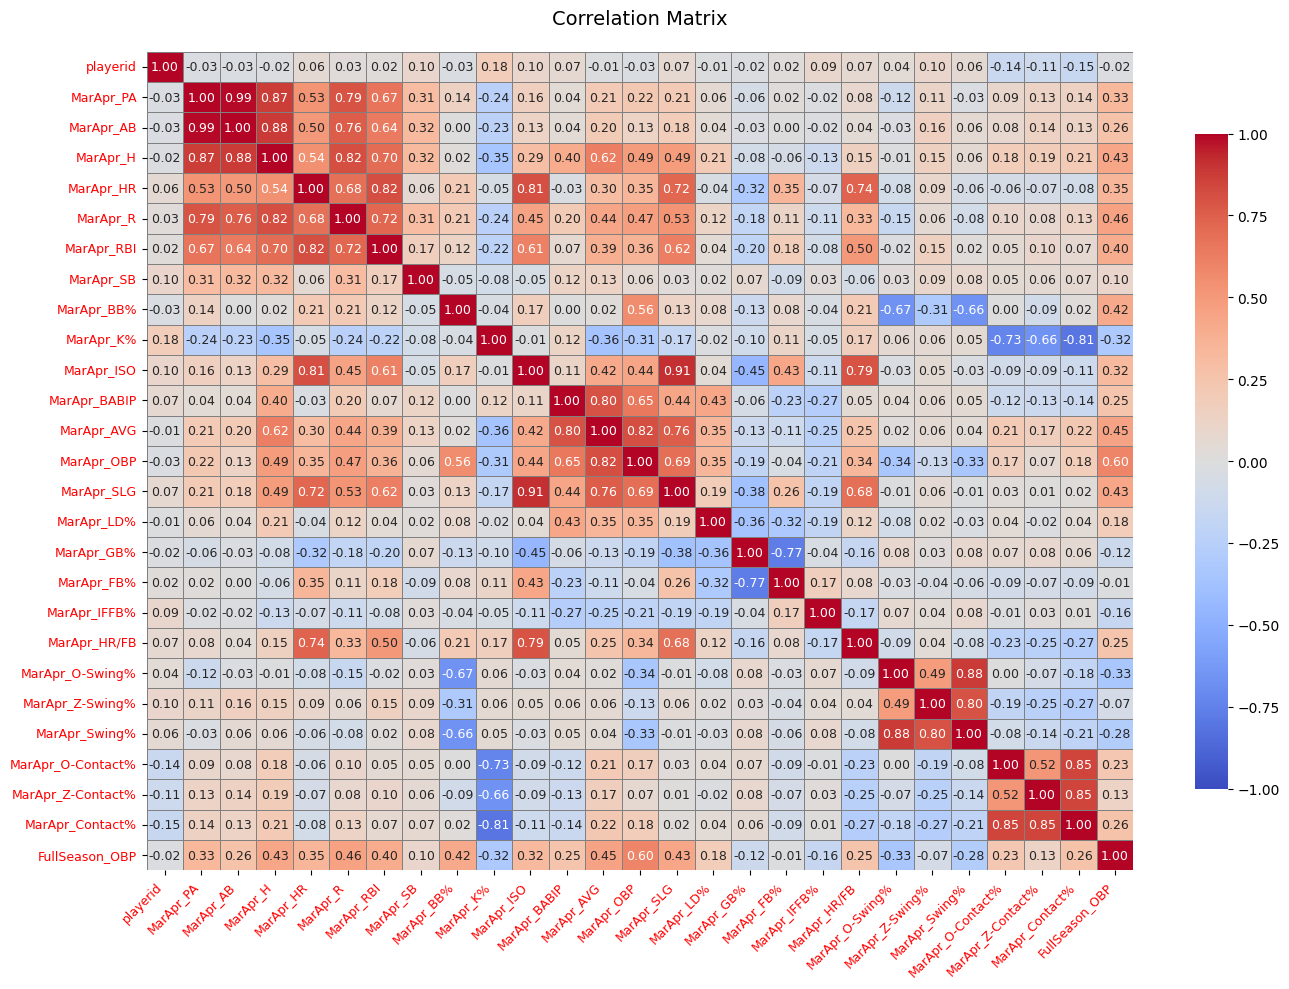

In [8]:
corr = df.corr().round(2)

plt.figure(figsize=(14, 10))  # Adjust size as needed
sns.heatmap(
    corr,
    annot=True,              # Show values
    fmt=".2f",               # 2 decimal places
    cmap='coolwarm',
    center=0,
    vmin=-1, vmax=1,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={"shrink": 0.8},
    square=False,
    annot_kws={"size": 9}    # Slightly smaller text
)

plt.title("Correlation Matrix", fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=9, color='red')  # Optional: red labels like R
plt.yticks(fontsize=9, color='red')
plt.tight_layout()  # Makes everything fit nicely

# Save the plot
plt.savefig(r'C:\Users\cboat\OneDrive\Documents\GitHub\On-base-Predictive-Model\correlation_plot.png',
            dpi=300, bbox_inches='tight')

plt.show()  # Shows it in notebook too

In [9]:
df = df.drop(['MarApr_SB', 
              'MarApr_RBI',
              'MarApr_R',
              'playerid',
              'MarApr_PA'], axis=1)
df.head()

,MarApr_AB,MarApr_H,MarApr_HR,MarApr_BB%,MarApr_K%,MarApr_ISO,MarApr_BABIP,MarApr_AVG,MarApr_OBP,MarApr_SLG,...,MarApr_FB%,MarApr_IFFB%,MarApr_HR/FB,MarApr_O-Swing%,MarApr_Z-Swing%,MarApr_Swing%,MarApr_O-Contact%,MarApr_Z-Contact%,MarApr_Contact%,FullSeason_OBP
0,109,47,14,14.4,11.4,0.459,0.398,0.431,0.508,0.890,...,36.1,5.7,40.0,22.6,66.0,40.7,81.1,88.4,86.0,0.406
1,102,36,14,16.1,16.1,0.451,0.319,0.353,0.460,0.804,...,41.0,11.8,41.2,27.9,72.4,44.8,56.6,87.8,75.7,0.429
2,32,13,2,2.9,14.3,0.313,0.440,0.406,0.457,0.719,...,33.3,0.0,22.2,40.2,74.5,53.5,54.3,85.4,71.1,0.315
3,43,17,3,10.2,10.2,0.302,0.400,0.395,0.458,0.698,...,40.5,0.0,20.0,27.3,50.5,37.3,93.9,97.8,96.2,0.353
4,71,22,8,21.7,21.7,0.423,0.318,0.310,0.457,0.732,...,51.9,7.4,29.6,23.7,48.8,33.7,66.1,82.7,75.7,0.341


In [10]:
np.random.seed(9816)

# Define target and features
target = 'FullSeason_OBP'
y = df[target]                    # Target variable
X = df.drop(columns=[target])     # All other columns as features

# First: Split off 70% for training, 30% for temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=9816
)

# Second: Split the temp 30% into 15% validation and 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=9816  # 50% of 30% = 15%
)

# Optional: Reset indices for clean DataFrames
X_train = X_train.reset_index(drop=True)
X_val   = X_val.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val   = y_val.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

# You can also recombine into full DataFrames if preferred
trainSet = pd.concat([X_train, y_train], axis=1)
valSet   = pd.concat([X_val,   y_val],   axis=1)
testSet  = pd.concat([X_test,  y_test],  axis=1)

# Verify the split
print(f"Training set:   {len(trainSet)} rows ({len(trainSet)/len(df):.1%})")
print(f"Validation set: {len(valSet)} rows   ({len(valSet)/len(df):.1%})")
print(f"Test set:       {len(testSet)} rows       ({len(testSet)/len(df):.1%})")
print(f"Target variable: '{target}'")

Training set:   224 rows (70.0%)
Validation set: 48 rows   (15.0%)
Test set:       48 rows       (15.0%)
Target variable: 'FullSeason_OBP'


Plot saved to: C:\Users\cboat\OneDrive\Documents\GitHub\On-base-Predictive-Model\model_comparison_validation.png


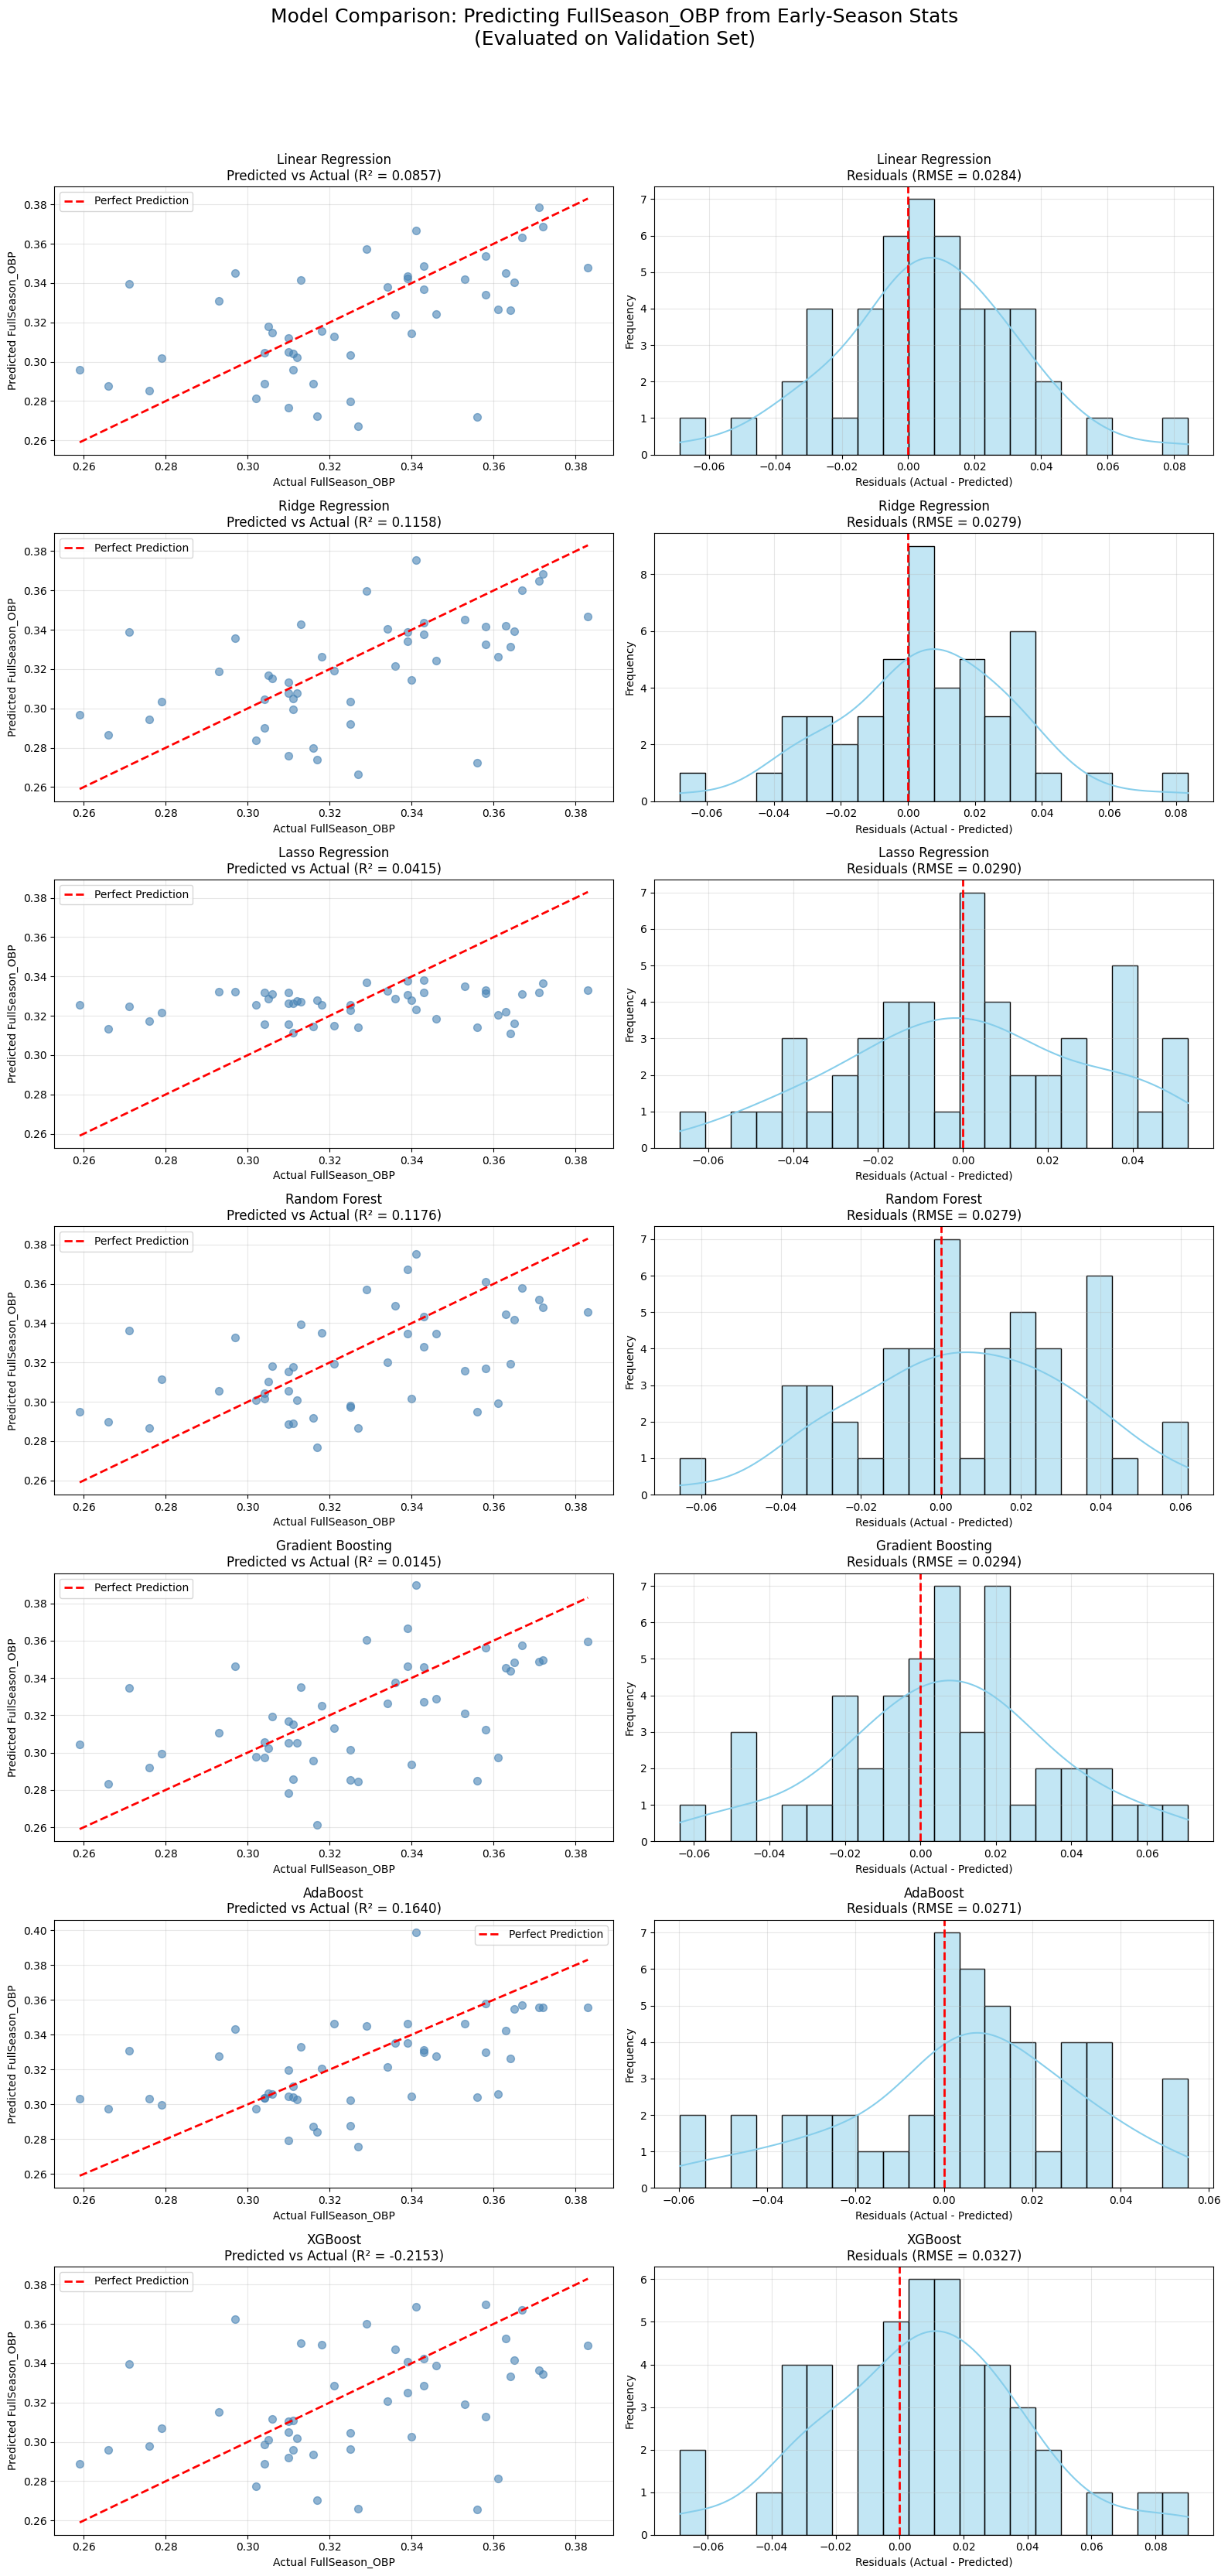


Best model (on validation set): AdaBoost
Validation RMSE: 0.0271
Validation R²:   0.1640


In [11]:
# 1. Define models
models = [
    ("Linear Regression", LinearRegression()),
    ("Ridge Regression", Ridge(alpha=1.0)),
    ("Lasso Regression", Lasso(alpha=0.1)),
    ("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42)),
    ("Gradient Boosting", GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ("AdaBoost", AdaBoostRegressor(n_estimators=100, random_state=42)),
    ("XGBoost", XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)),
]

# 2. Setup the grid: 7 models → 7 rows, 2 columns
fig, axes = plt.subplots(nrows=len(models), ncols=2, figsize=(16, 5 * len(models)))

best_model_name = None
best_model = None
best_rmse = float("inf")
best_r2 = -float("inf")

# 3. Train and evaluate each model on VALIDATION set
for i, (name, model) in enumerate(models):
    # Fit on training data
    model.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred_val = model.predict(X_val)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    r2 = r2_score(y_val, y_pred_val)
    
    # Track best performing model (lowest RMSE)
    if rmse < best_rmse:
        best_rmse = rmse
        best_r2 = r2
        best_model_name = name
        best_model = model

    # --- Left Plot: Predicted vs Actual (Validation) ---
    ax_scatter = axes[i, 0] if len(models) > 1 else axes[0]
    ax_scatter.scatter(y_val, y_pred_val, alpha=0.6, color='steelblue', s=50)
    ax_scatter.plot([y_val.min(), y_val.max()], 
                    [y_val.min(), y_val.max()], 
                    'r--', lw=2, label="Perfect Prediction")
    ax_scatter.set_xlabel("Actual FullSeason_OBP")
    ax_scatter.set_ylabel("Predicted FullSeason_OBP")
    ax_scatter.set_title(f"{name}\nPredicted vs Actual (R² = {r2:.4f})")
    ax_scatter.legend()
    ax_scatter.grid(True, alpha=0.3)

    # --- Right Plot: Residuals ---
    ax_resid = axes[i, 1] if len(models) > 1 else axes[1]
    residuals = y_val - y_pred_val
    sns.histplot(residuals, kde=True, bins=20, color='skyblue', ax=ax_resid)
    ax_resid.axvline(x=0, color='red', linestyle='--', lw=2)
    ax_resid.set_xlabel("Residuals (Actual - Predicted)")
    ax_resid.set_ylabel("Frequency")
    ax_resid.set_title(f"{name}\nResiduals (RMSE = {rmse:.4f})")
    ax_resid.grid(True, alpha=0.3)

# 4. Final formatting
plt.suptitle("Model Comparison: Predicting FullSeason_OBP from Early-Season Stats\n"
             "(Evaluated on Validation Set)", fontsize=18, y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the figure
save_path = r'C:\Users\cboat\OneDrive\Documents\GitHub\On-base-Predictive-Model\model_comparison_validation.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Plot saved to: {save_path}")

plt.show()

# 5. Print results
print(f"\nBest model (on validation set): {best_model_name}")
print(f"Validation RMSE: {best_rmse:.4f}")
print(f"Validation R²:   {best_r2:.4f}")

------------------------------
FINAL PROOF ON TEST SET
------------------------------
Best Model: AdaBoost
Test RMSE:  0.0286
Test R²:    0.4493
------------------------------
Plot saved to: C:\Users\cboat\OneDrive\Documents\GitHub\On-base-Predictive-Model\final_test_evaluation.png


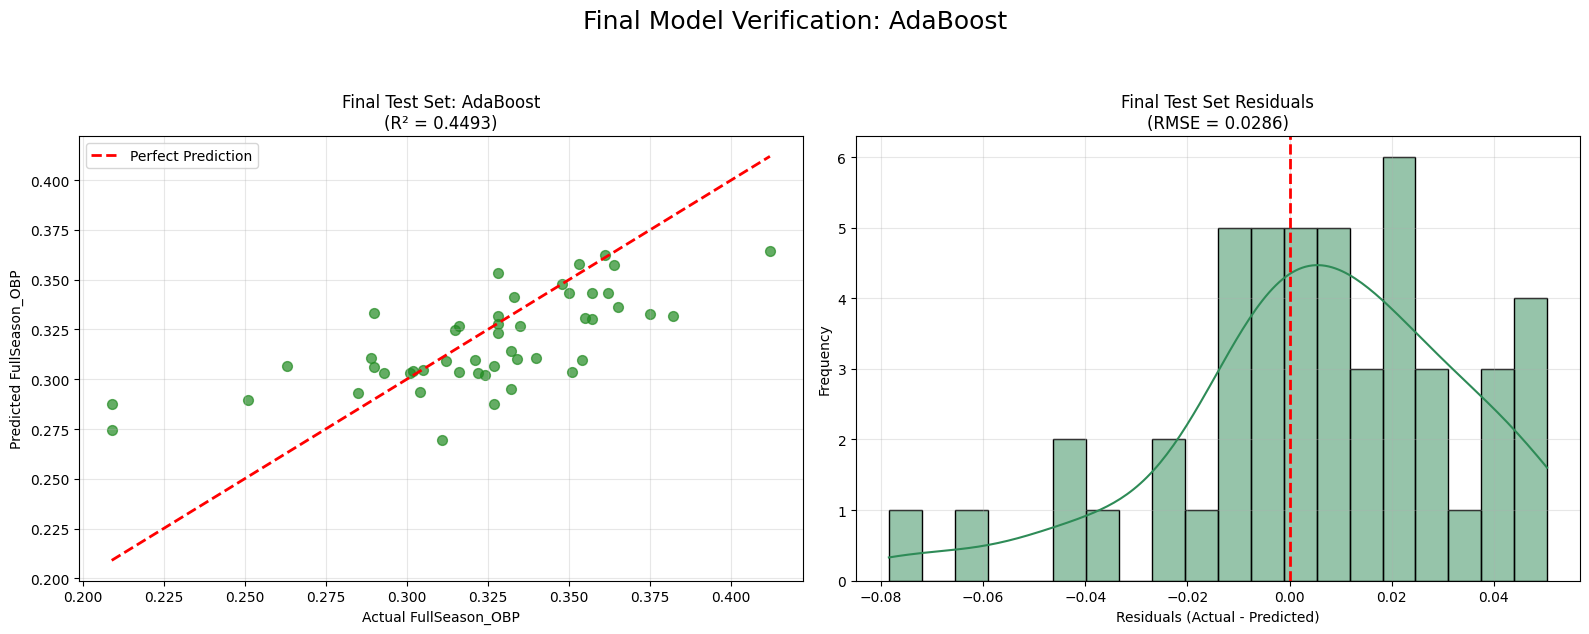

In [12]:
# 1. Predict on the Test Set using the winner from your loop
y_pred_test = best_model.predict(X_test)

# 2. Calculate Final Metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)

# 3. Visualization: Test Set Performance
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# --- Left Plot: Predicted vs Actual (Test) ---
ax_scatter = axes[0]
ax_scatter.scatter(y_test, y_pred_test, alpha=0.7, color='forestgreen', s=50)
ax_scatter.plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', lw=2, label="Perfect Prediction")
ax_scatter.set_xlabel("Actual FullSeason_OBP")
ax_scatter.set_ylabel("Predicted FullSeason_OBP")
ax_scatter.set_title(f"Final Test Set: {best_model_name}\n(R² = {test_r2:.4f})")
ax_scatter.legend()
ax_scatter.grid(True, alpha=0.3)

# --- Right Plot: Residuals (Test) ---
ax_resid = axes[1]
test_residuals = y_test - y_pred_test
sns.histplot(test_residuals, kde=True, bins=20, color='seagreen', ax=ax_resid)
ax_resid.axvline(x=0, color='red', linestyle='--', lw=2)
ax_resid.set_xlabel("Residuals (Actual - Predicted)")
ax_resid.set_ylabel("Frequency")
ax_resid.set_title(f"Final Test Set Residuals\n(RMSE = {test_rmse:.4f})")
ax_resid.grid(True, alpha=0.3)

# Final formatting
plt.suptitle(f"Final Model Verification: {best_model_name}", fontsize=18, y=1.05)
plt.tight_layout()

# Save the test evaluation
test_save_path = r'C:\Users\cboat\OneDrive\Documents\GitHub\On-base-Predictive-Model\final_test_evaluation.png'
plt.savefig(test_save_path, dpi=300, bbox_inches='tight')

# 4. Print Final Results
print("-" * 30)
print(f"FINAL PROOF ON TEST SET")
print("-" * 30)
print(f"Best Model: {best_model_name}")
print(f"Test RMSE:  {test_rmse:.4f}")
print(f"Test R²:    {test_r2:.4f}")
print("-" * 30)
print(f"Plot saved to: {test_save_path}")

plt.show()

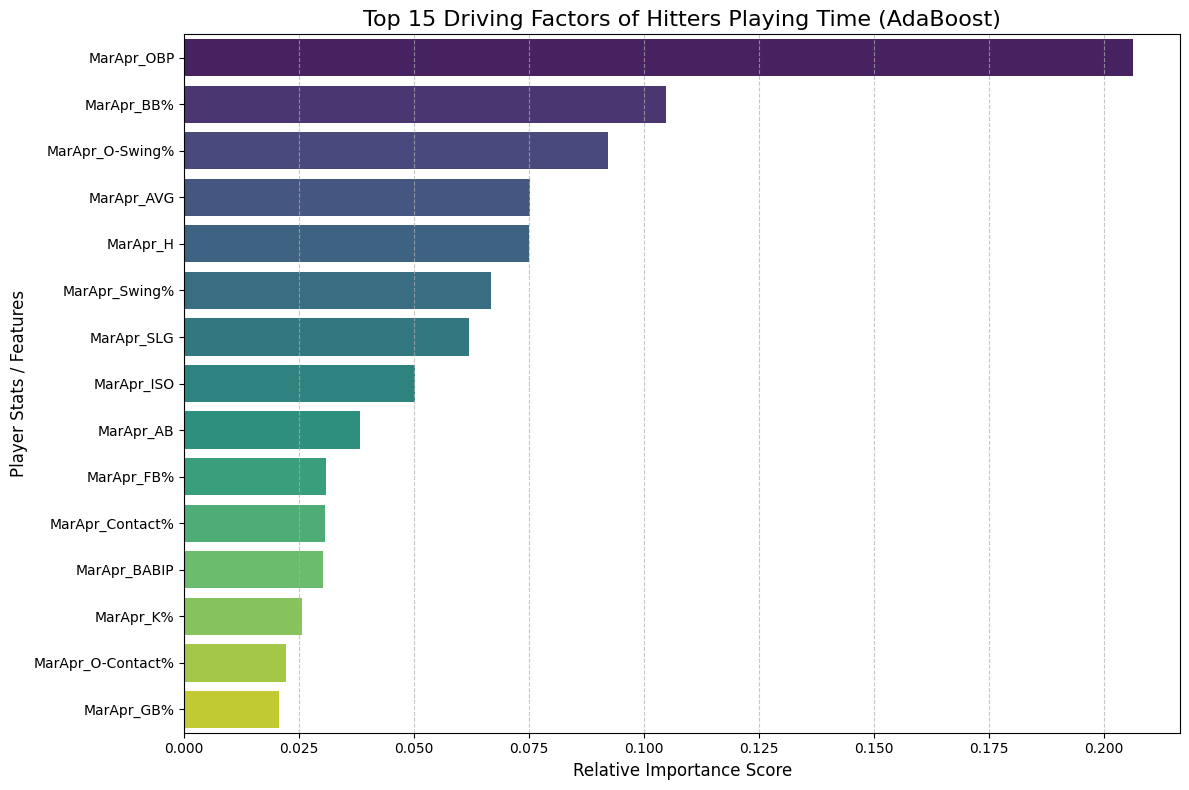

In [13]:
# 1. Extract feature importances
# This works for Random Forest, Gradient Boosting, and AdaBoost
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_names = X_train.columns
    
    # Create a DataFrame for easy sorting
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # 2. Plotting
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='Importance', 
        y='Feature', 
        data=feature_importance_df.head(15), # Show top 15 drivers
        palette='viridis'
    )

    # Add labels and title
    plt.title(f'Top 15 Driving Factors of Hitters Playing Time ({best_model_name})', fontsize=16)
    plt.xlabel('Relative Importance Score', fontsize=12)
    plt.ylabel('Player Stats / Features', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Ensure no clipping of labels
    plt.tight_layout()
    plt.savefig(r'C:\Users\cboat\OneDrive\Documents\GitHub\On-base-Predictive-Model\Feature_Importance_On_base.png')
    plt.show()

elif hasattr(best_model, 'coef_'):
    # If the best model was Linear, Ridge, or Lasso
    importances = np.abs(best_model.coef_)
    feature_names = X_train.columns
    # (Similar plotting logic as above for coefficients)
    print("Linear model detected: Plotting absolute coefficient weights.")
else:
    print("This model type does not support standard feature importance visualization.")